# TN test analysis framework using OVR

We use scanpy's implementation of Seurat's tutorial. See [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). Execute the following bash commands to download the tutorial PBMC dataset:

```
mkdir data;
wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz;
cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
```

In [6]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind

def plot_labels_legend(x1, x2, Y):
    for i in np.unique(Y):
        plt.plot(x1[Y == i], x2[Y == i], '.',
                 label=r'%s ($n$ = %s)'%(i, np.sum(Y==i)))
    plt.legend()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load data
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)
X = adata.X
features = np.array(adata.var['gene_ids'].index)
tsne = np.array(pd.read_csv(os.path.join('./pbmc_seurat_tsne.txt'), delimiter=' '))

In [8]:
def scanpy_cluster(X, features, tsne=None, plot=False, resolution=1.0):
    "Scanpy implementation of Seurat's pipeline"

    adata = sc.AnnData(X=X)
    adata.var['genes_ids'] = features

    # preprocessing
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    sc.pp.scale(adata, max_value=10)

    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.louvain(adata, resolution=resolution)
    
    if plot:
        if tsne is not None:
            adata.obsm['X_tsne'] = tsne
        else:
            sc.tl.tsne(adata)
        sc.pl.tsne(adata, color=['louvain'])

    labels = np.array(adata.obs['louvain'].astype(int))
    
    return labels

# 1. Split the dataset

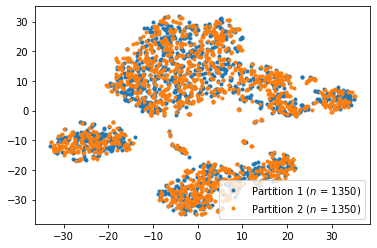

In [9]:
np.random.seed(0)
n = X.shape[0]
inds1 = np.sort(np.random.choice(range(n), n//2, replace=False))
inds2 = np.ones(n).astype(bool)
inds2[inds1] = False
X1, X2 = X[inds1], X[inds2]

samp_labels = np.array(['Partition 1' if i else 'Partition 2' for i in inds2])
plot_labels_legend(tsne[:, 0], tsne[:, 1], samp_labels)

# 2. Generate clusters using X1

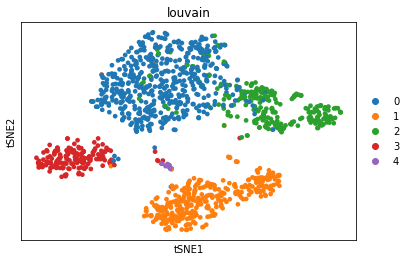

In [11]:
labels1 = scanpy_cluster(X1, features, tsne=tsne[inds1], plot=True, resolution=1)

# 3. Fit hyperplanes using X1

In [12]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=100)
svm.fit(X1, labels1)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# 4. General labels using hyperplanes and X2

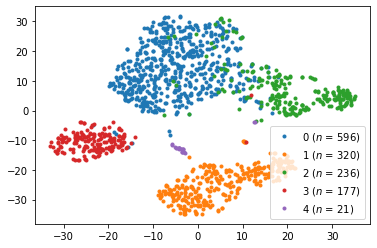

In [13]:
labels2 = svm.predict(X2)
plot_labels_legend(tsne[inds2, 0], tsne[inds2, 1], labels2)

# 5. Perform differential expression

In [14]:
# np.set_printoptions(precision=2)
# for i in range(5):
#     print(i, np.mean(np.dot(X2[labels2 == i], svm.coef_.T) + svm.intercept_ > 0, 0))

np.random.seed(0)

picklefile = 'pbmc_tntest_tutorial.pickle'
if os.path.isfile(picklefile):
    results = pickle.load(open(picklefile, 'rb'))
else:
    results = {}
    
start = time.time()
for i, (c1, c2) in enumerate(itertools.combinations(np.unique(labels2), 2)):
    if (c1, c2) in results:
        continue
    p_t = ttest_ind(X1[labels1 == c1].todense(), X1[labels1 == c2].todense())[1]
    p_t[np.isnan(p_t)] = 1
    y = np.array(X2[labels2 == c1].todense())
    z = np.array(X2[labels2 == c2].todense())
    a = np.array(svm.coef_[i].todense()).reshape(-1)
    b = svm.intercept_[i]
    p_tn, likelihood = tn.tn_test(y, z, a=a, b=b,
                                  learning_rate=1.,
                                  eps=1e-2,
                                  verbose=True,
                                  return_likelihood=True,
                                  num_iters=100000,
                                  num_cores=64)
    results[(c1, c2)] = (p_t, p_tn)
    print('c1: %5s\tc2: %5s\ttime elapsed: %.2fs'%(c1, c2, time.time()-start))
    pickle.dump(results, open(picklefile, 'wb'))

Number of genes with 0 variance across cells: 18349
100000 iterations done; likelihood = 1.46e+07 (526.94 s elapsed).
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   52.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  4.8min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  8.4min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed: 10.6min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed: 12.9min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 16.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 20.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 25.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 30.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapse

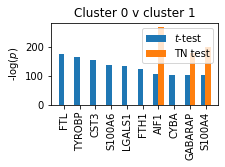

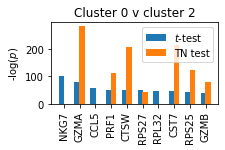

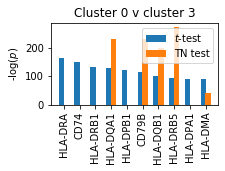

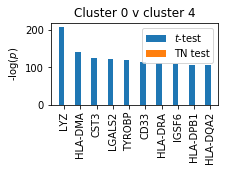

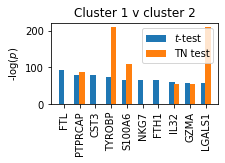

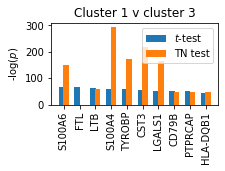

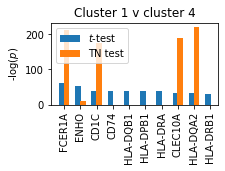

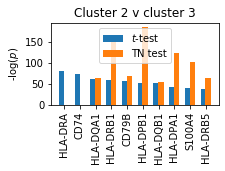

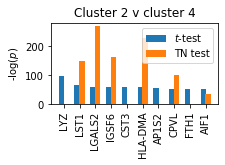

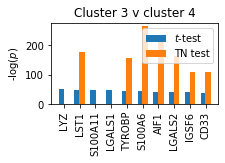

In [15]:
# visualize results
ngenes = 10
ind = np.arange(ngenes)

for c1, c2 in sorted(results):
    p_t, p_tn = results[(c1, c2)]
    gene_inds = np.argsort(p_t)[:ngenes]
    gene_names = features[gene_inds]
    
    fig, ax = plt.subplots(figsize=(3, 1.5))
    rects = ax.bar(ind-0.2,
                   -np.log10(p_t[gene_inds]), 
                   0.35,
                   align='center',
                   label=r'$t$-test')
    rects = ax.bar(ind-0.2+0.3,
                   -np.log10(p_tn[gene_inds]),
                   0.35,
                   align='center',
                   label='TN test')
    ax.set_ylabel('-log($p$)')
    xticks_pos = [0.65*patch.get_width()+patch.get_xy()[0]-0.2 for patch in rects]
    plt.xticks(np.array(xticks_pos), gene_names, rotation=90)
    plt.legend()
    plt.title('Cluster %s v cluster %s'%(c1, c2))
    plt.show()

# 6. Overall pipeline

In [16]:
def tn_test_framework(X, clustering_algorithm, ngenes=10, verbose=True,
                      **kwargs):
    """
    The TN test framework as described in
    https://www.biorxiv.org/content/early/2018/11/05/463265.

    Parameters
    ----------
    X: input data with dimension (num_cells)-by-(num_features)
    clustering_algorithm: a function that returns labels for input data
        (cells)
    ngenes: number of genes to test (TN test is relatively slow and should
        primarily be used to double-check markers chosen by other methods.
        We compare against t-test by default)

    Returns
    ----------
    X1: first half of dataset used to generate labels
    X2: second half of dataset used to run differential expression analysis
    y1: labels for first half
    y2: labels for second half
    de: dictionary of pairwise differential expression
    """
    
    # Split the dataset
    n = X.shape[0]
    inds1 = np.sort(np.random.choice(range(n), n//2, replace=False))
    inds2 = np.ones(n).astype(bool)
    inds2[inds1] = False
    X1, X2 = X[inds1], X[inds2]
    
    # Clustering
    y1 = clustering_algorithm(X1)
    
    # Fit linear separator using X1
    svm = SVC(kernel='linear', C=100)
    svm.fit(X1, y1)
    
    # Generate labels for X2
    y2 = svm.predict(X2)
    
    # Perform differential expression
    de = {}
    if verbose:
        start = time.time()
    for i, (c1, c2) in enumerate(itertools.combinations(np.unique(y2), 2)):
        p_t = ttest_ind(X1[y1 == c1].todense(), X1[y1 == c2].todense())[1]
        p_t[np.isnan(p_t)] = 1
        y = np.array(X2[y2 == c1].todense())
        z = np.array(X2[y2 == c2].todense())
        a = np.array(svm.coef_[i].todense()).reshape(-1)
        p_tn = tn.tn_test(y, z, a=a,
                          intercept=svm.intercept_[i],
                          learning_rate=1.,
                          eps=1e-2,
                          verbose=verbose,
                          num_iters=100000,
                          num_cores=64,
                          **kwargs)
        de[(c1, c2)] = (p_t, p_tn)
        if verbose:
            print('c1: %5s\tc2: %5s\ttime elapsed: %.2fs'%(c1, c2, time.time()-start))
            
    return X1, X2, y1, y2, de

In [17]:
def clustering_algorithm(X):
    return scanpy_cluster(X1, features, resolution=1)
    
X1, X2, y1, y2, de = tn_test_framework(X, clustering_algorithm)

TypeError: tn_test() got an unexpected keyword argument 'intercept'